In [ ]:
import keras
import random
from keras import backend as K
import warnings
warnings.filterwarnings("ignore")

In [ ]:

#Letters present in the Label Text
letters= '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [ ]:
#image height
img_h=32
#image width
img_w=170
#image Channels
img_c=1
# classes for softmax with number of letters +1 for blank space in ctc
num_classes=len(letters)+1
batch_size=64
max_length=15 # considering max length of ground truths labels to be 15

In [ ]:
def encode_words_labels(word):
    """
    Encodes the Ground Truth Labels to a list of Values like eg.HAT returns [17,10,29]
    """
    label_lst=[]
    for char in word:
        label_lst.append(letters.find(char)) # keeping 0 for blank and for padding labels
    return label_lst

In [ ]:
def words_from_labels(labels):
    """
    converts the list of encoded integer labels to word strings like eg. [12,10,29] returns CAT
    """
    txt=[]
    for ele in labels:
        if ele == len(letters): # CTC blank space
            txt.append("")
        else:
            #print(letters[ele])
            txt.append(letters[ele])
    return "".join(txt)

In [ ]:
def ctc_loss_function(args):
    """
    CTC loss function takes the values passed from the model returns the CTC loss using Keras Backend ctc_batch_cost function
    """
    y_pred, y_true, input_length, label_length = args
    # since the first couple outputs of the RNN tend to be garbage we need to discard them, found this from other CRNN approaches
    # I Tried by including these outputs but the results turned out to be very bad and got very low accuracies on prediction
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(y_true, y_pred, input_length, label_length)

In [ ]:
#https://github.com/qjadud1994/CRNN-Keras
#https://keras.io/examples/image_ocr/

class DataGenerator(keras.callbacks.Callback):
    def __init__(self, img_dirpath, img_w, img_h,
                 batch_size,n,output_labels,max_text_len=15):
        self.img_h = img_h                    #Image Height
        self.img_w = img_w                    #Image Width
        self.batch_size = batch_size          #Batch size of Input
        self.max_text_len = max_text_len      #Maximum Text length of Labels

#         self.n =len(self.img_dir)                           #Number of images in img_matrix
        self.n=n
        self.img_dir = img_dirpath[:self.n]     # images list
        self.indexes = list(range(self.n))   #List of indices for each image in img_matrix
        self.cur_index = 0                   #Current index which points to image being loaded
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts =  output_labels[:self.n]                  #List of Ground Truth Label texts


    def build_data(self):
        """
        Build The Image Data
        """
        print(self.n, " Image Loading start...")
        for i, img_file in enumerate(self.img_dir):
            img = cv2.imread(img_file)
            img = img[:,:,1]                               #Extracting Single Channel Image
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img /255
            self.imgs[i, :, :]= img
            if i%10000==0:
                print("Loaded Images: ",i)

        print("Number of Texts matches with Total Number of Images :",len(self.texts) == self.n)
        print(self.n, " Image Loading finish...")


    def next_data(self):
        """
        Returns image and text data pointed by the current index
        """
        self.cur_index += 1
        #If current index becomes more than the number of images, make current index 0
        #and shuffle the indices list for random picking of image and text data
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]

    def next_batch(self):
        """
        Creates a batch of images images and text data equal to the batch_size,
        computes the parameters needed for CTC and returns the inputs to the Model
        """
        while True:
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])  #Single channel Gray Size Scale images for input
            #Initilizing with -1 to aid for padding labels of different lengths
            Y_data = np.ones([self.batch_size, self.max_text_len])* -1        #Text labels for input
           #input_length for CTC which is the number of time-steps of the RNN output
            input_length = np.ones((self.batch_size, 1)) * 40
            label_length = np.zeros((self.batch_size, 1))                   #label length for CTC
            source_str=[]                                                   #List to store Ground Truth Labels
            for i in range(self.batch_size):
                img, text = self.next_data() #getting the image and text data pointed by current index
                                    #taking transpose of image
                img=img.T
                img = np.expand_dims(img, -1)  #expanding image to have a single channel
                X_data[i] = img
                label=encode_words_labels(text) # encoding label text to integer list and storing in temp label variable
                lbl_len=len(label)
                Y_data[i,0:lbl_len] = label #Storing the label till its length and padding others
                label_length[i] = len(label)
                source_str.append(text) #storing Ground Truth Labels which will be accessed as reference for calculating metrics

        #Preparing the input for the Model
            inputs = {
                'img_input': X_data,
                'ground_truth_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
                'source_str': source_str  # used for visualization only
            }
            #Preparing output for the Model and intializing to zeros
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs) # Return the Prepared input and output to the Model

In [ ]:
from keras.layers import Input, Conv2D, MaxPool2D, Dense,MaxPooling2D
from keras.layers import AveragePooling2D, Flatten, Activation, Bidirectional
from keras.layers import BatchNormalization, Dropout
from keras.layers import Concatenate, Add, Multiply, Lambda
from keras.layers import UpSampling2D, Reshape
from keras.layers import add,concatenate
from keras.layers import Reshape
from keras.models import Model
from keras.layers import LSTM,GRU
import tensorflow as tf

In [ ]:
def Image_text_recogniser_model_1(stage,drop_out_rate=0.35):
    """
    Builds the model by taking in the stage variable which specifes the stage,
    if the stage is training: model takes inputs required for computing ctc_batch_cost function
    else : model takes input as images which is used for prediction
    """

    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)

    model_input=Input(shape=input_shape,name='img_input',dtype='float32')

    # Convolution layer
    model = Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(model_input)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max1')(model)

    model = Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(2, 2), name='max2')(model)

    model = Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max3')(model)

    model = Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = Conv2D(512, (3, 3), padding='same', name='conv6')(model)
    model=Dropout(drop_out_rate)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)
    model = MaxPooling2D(pool_size=(1, 2), name='max4')(model)

    model = Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(model)
    model=Dropout(0.25)(model)
    model = BatchNormalization()(model)
    model = Activation('relu')(model)

    # CNN to RNN
    model = Reshape(target_shape=((42, 1024)), name='reshape')(model)
    model = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(model)

    # RNN layer
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='sum')(model)
    model=Bidirectional(LSTM(256, return_sequences=True, kernel_initializer='he_normal'), merge_mode='concat')(model)

    # transforms RNN output to character activations:
    model = Dense(num_classes, kernel_initializer='he_normal',name='dense2')(model)
    y_pred = Activation('softmax', name='softmax')(model)


    labels = Input(name='ground_truth_labels', shape=[max_length], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')

    #CTC loss function
    loss_out = Lambda(ctc_loss_function, output_shape=(1,),name='ctc')([y_pred, labels, input_length, label_length]) #(None, 1)

    if stage=='train':
        return model_input,y_pred,Model(inputs=[model_input, labels, input_length, label_length], outputs=loss_out)
    else:
        return Model(inputs=[model_input], outputs=y_pred)

In [ ]:
model_input,y_pred,img_text_recog=Image_text_recogniser_model_1('train')

In [ ]:
#used for visualization
# it is a keras backend function used to capture the model ouputs so that it can be used for decoding and calculating metrics
test_func = K.function([model_input], [y_pred])

In [ ]:
img_text_recog.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 img_input (InputLayer)      [(None, 170, 32, 1)]         0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 170, 32, 64)          640       ['img_input[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 170, 32, 64)          256       ['conv1[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 170, 32, 64)          0         ['batch_normalization[0][0

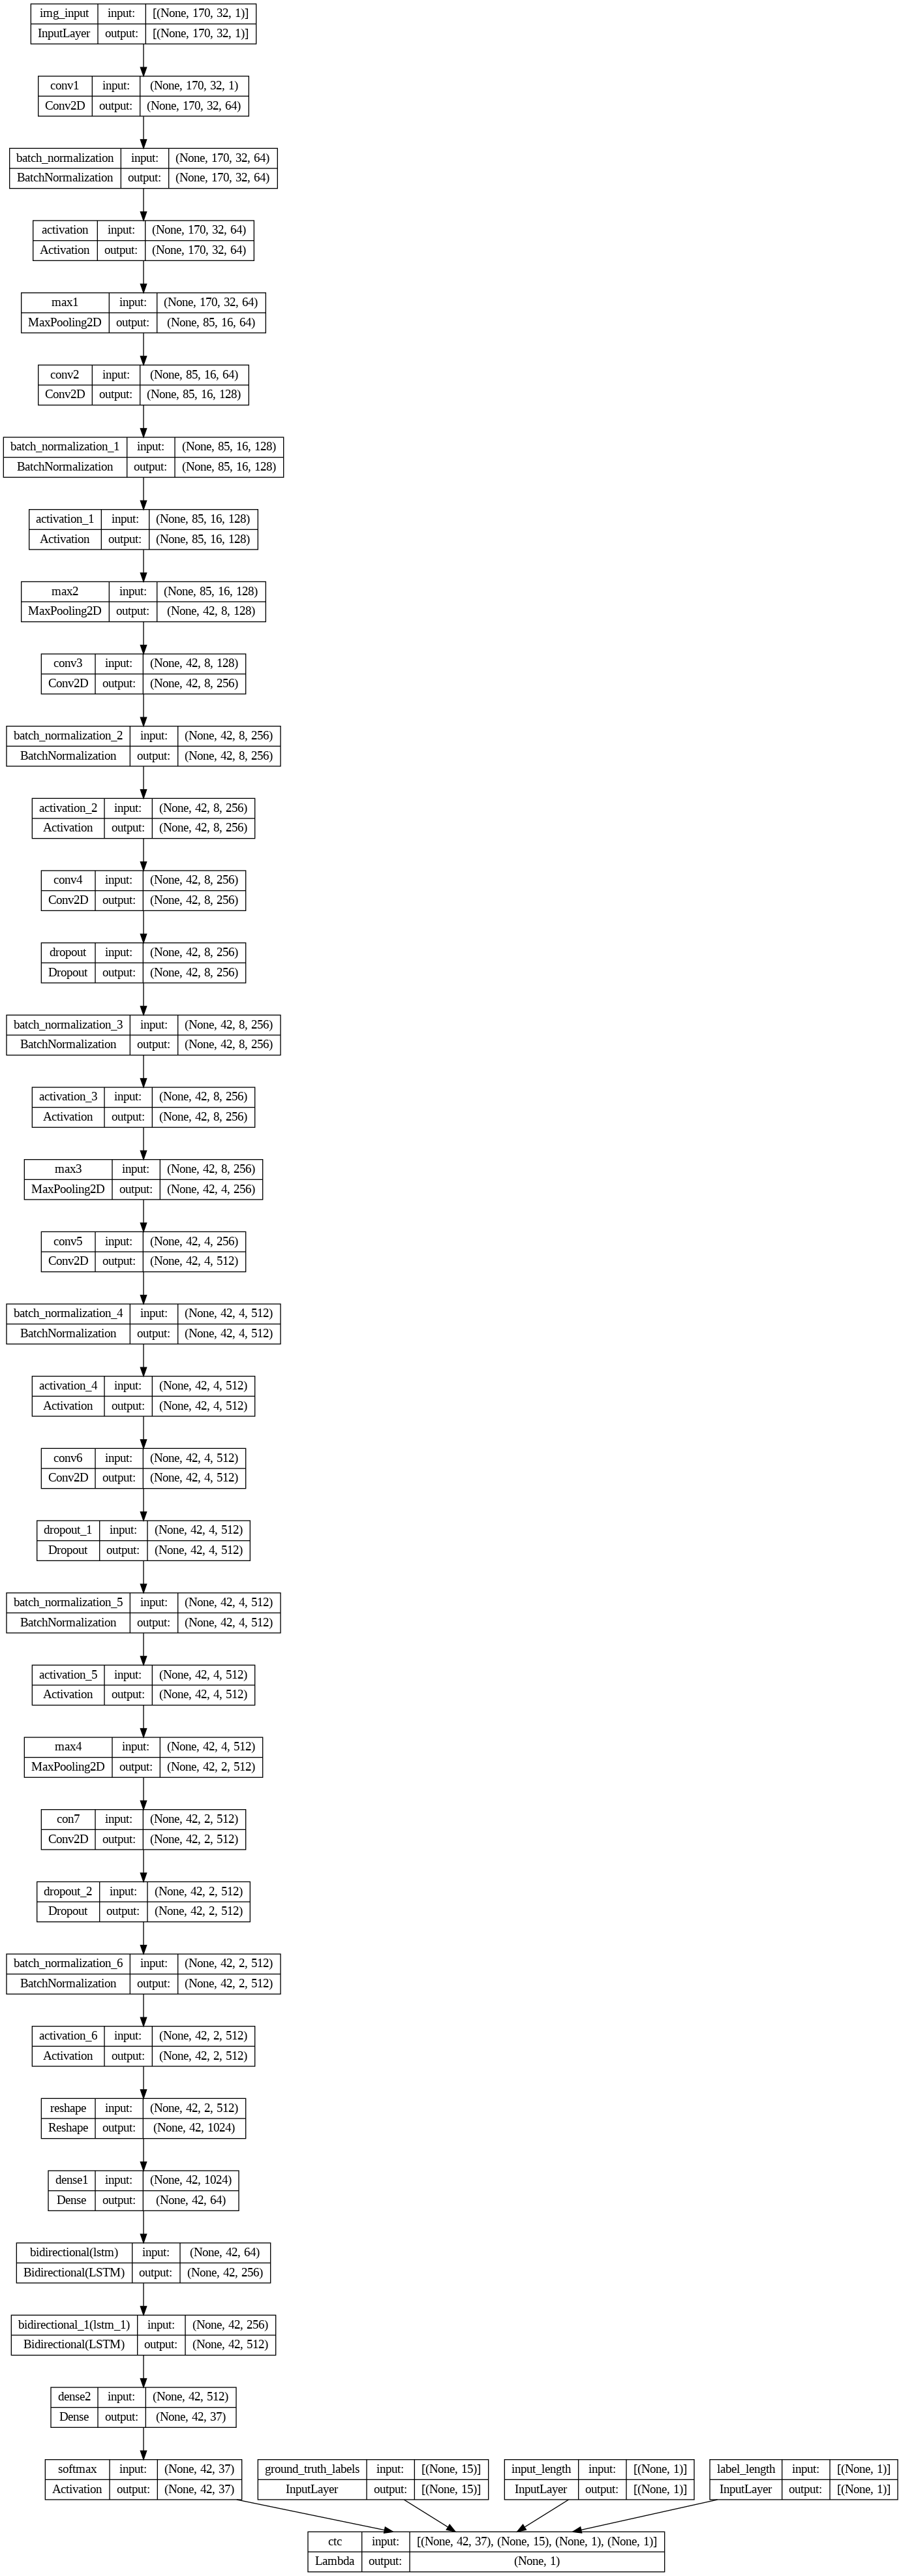

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(img_text_recog, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)